# Pytorch RNN

A recurrent neural network written in pytorch.

## Imports

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# pixel permutation idxs
perm_idxs = list(range(num_pixels))
np.random.RandomState(seed=0).shuffle(perm_idxs)

# reverse pixel permutation idxs
rev_perm_idxs = [perm_idxs.index(i) for i in range(num_pixels)]

# Training Parameters
num_steps = 2000 # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Batch size
test_batch_size = 1000 # batch size for calculating the validation/test loss

# RNN Parameters
num_inputs = 1 # input dimension [1=pixel-by-pixel]
num_steps_rnn = num_pixels // num_inputs # sequential dimensionality of rnn
num_hidden_rnn = 128 # hidden layer dimension
num_layers_rnn = 1 # number of hidden layers

# Optimization parameters
learning_rate = 0.0002 # learning rate

# cuda
cuda = True
device = torch.device('cuda' if cuda else 'cpu')

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

The image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In contrast with the Convolutional Neural Networks, we do a pixel-by-pixel recognition of the digit image where the individial pixels are permuted with a fixed permutation defined by `perm_idx`. This fixed permutation is necessary for good performance of the RNN, as otherwise the the end of the pixel stream contains too many zeros for the RNN to retain its internal state. This is a good benchmark task for a recurrent neural network. The performance of this architecture will obviously be worse than for a convnet.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = torch.tensor(data[:,0], dtype=torch.int64, device=device)
    values = torch.tensor(data[:,1:][:,perm_idxs]/255, dtype=torch.float32, device=device).view(-1, num_steps_rnn, num_inputs)
    return values, labels
    
train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)

print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	torch.Size([50000, 784, 1])
train labels shape:	torch.Size([50000])


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

In [1]:
def show_digit(digit_array):
    plt.imshow(digit_array.cpu().numpy().reshape(num_pixels)[rev_perm_idxs].reshape(width, height), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

NameError: name 'train_values' is not defined

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers. We use the `torch.nn.Module` to create the network.

In [5]:
# Create RNN Model
class Model(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden_rnn, num_layers_rnn, num_labels):
        super(Model, self).__init__()
        
        # RNN
        self.rnn = torch.nn.LSTM(num_inputs, num_hidden_rnn, num_layers_rnn, batch_first=True)
        
        # Readout layer
        self.fc = torch.nn.Linear(num_hidden_rnn, num_labels)
        
        # move to device
        self.to(device)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.randn((num_layers_rnn, x.shape[0], num_hidden_rnn), device=device)
        c0 = torch.randn((num_layers_rnn, x.shape[0], num_hidden_rnn), device=device)
            
        # One time step
        out, (hn, cn) = self.rnn(x, (h0, c0))
        #out, hn = self.rnn(x, h0)
        
        out = self.fc(out[:, -1, :]) 
        return out


# Train

Create the model

In [6]:
model = Model(num_inputs, num_hidden_rnn, num_layers_rnn, num_labels)

We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp

In [7]:
# loss
lossfunc = torch.nn.CrossEntropyLoss()

# accuracy
def accuracy(logits, labels):
    return 100*np.mean(np.argmax(logits.data.cpu().numpy(), 1) == labels.data.cpu().numpy())

# RMSprop Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

Start the training

In [8]:
%%time
history = []

for step in range(num_steps):
    # reset gradients
    optimizer.zero_grad()
    
    # calculate validation accuracy and loss
    with torch.no_grad():
        if step%(train_size//batch_size) == 0 or step == num_steps - 1:
            val_acc = np.zeros(valid_size//test_batch_size)
            val_loss = np.zeros(valid_size//test_batch_size)
            # we need to split the calculation of the validation loss in batches
            # to avoid memory problems.
            for i in range(0, valid_size, test_batch_size):
                valid_logits = model(valid_values[i:i+test_batch_size])
                val_loss[i//test_batch_size] = lossfunc(valid_logits, valid_labels[i:i+test_batch_size]).item()
                val_acc[i//test_batch_size] = accuracy(valid_logits, valid_labels[i:i+test_batch_size]).item()
            history.append((step, val_loss.mean(), val_acc.mean()))
            print(f'Step {step:5.0f}\t Valid. Acc. = {val_acc.mean():5.2f}')

    # train
    idxs = np.random.randint(0, train_size, batch_size)
    batch_values = train_values[idxs]
    batch_labels = train_labels[idxs]
    logits = model(batch_values)
    loss = lossfunc(logits, batch_labels)
    loss.backward()
    optimizer.step()

Step     0	 Valid. Acc. =  9.00
Step   500	 Valid. Acc. = 11.07
Step  1000	 Valid. Acc. = 25.25
Step  1500	 Valid. Acc. = 28.66
Step  1999	 Valid. Acc. = 33.65
CPU times: user 1min 53s, sys: 18.4 s, total: 2min 11s
Wall time: 2min 11s


Note that the pytorch implementation is about 5 times faster than the tensorflow implementation!

Training history:

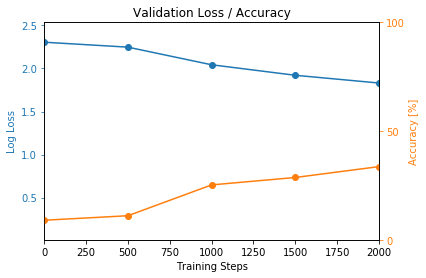

In [9]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
m = (min(acc)-1)//10*10; plt.ylim(m,100)
plt.yticks([m,(m+100)//2,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
m = 1.1*max(loss)
plt.ylim(0.01, m)

plt.xlim(0, (max(steps)+100)//100*100)
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

note that we could run this longer for better accuracy.

## Test

Finally, the accuracy on the test set can be evaluated:

In [10]:
with torch.no_grad():
    # we need to split the calculation of the test loss in batches
    # to avoid memory problems.
    test_accuracy = np.zeros(test_size//test_batch_size)
    for i in range(0, test_size, test_batch_size):
        test_logits = model(test_values[i:i+test_batch_size])
        test_accuracy[i//test_batch_size] = accuracy(test_logits, test_labels[i:i+test_batch_size]).item()
test_accuracy = test_accuracy.mean()
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 35.57


Visualize an example

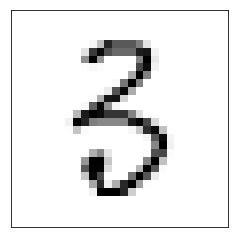

prediction=5	target=3


In [11]:
N = 315
show_digit(test_values[N])
test_logits = model(test_values[N:N+1])
prediction = torch.argmax(test_logits[0]).item()
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')